# Final LDA Model

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # Author: don't skip this
# pyLDAvis.gensim.prepare

# I think i need another one:
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')
stop_words.extend(['tenlastelegging\\n\\n\\naan', '\\n\\n\\n\\n\\n\\n', '\\n\\n\\n\\n\\n', '\\n\\n'])

# Data

In [5]:
# Data
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/DataSample_DSP_0712.csv', index_col=1) 
df = df[df['re_tll'] != '[]'][['re_tll']] #re_bewijs
# data = [i for i in df['re_tll']]

# Tokenize 

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['re_tll']))

print(data_words[:1])

[['tenlastelegging', 'naan', 'verdachte', 'is', 'ten', 'laste', 'gelegd', 'dat', 'nhij', 'in', 'of', 'omstreeks', 'de', 'periode', 'van', 'november', 'tot', 'en', 'met', 'november', 'in', 'arnhem', 'en', 'of', 'in', 'nederland', 'en', 'of', 'in', 'duitsland', 'en', 'of', 'in', 'oostenrijk', 'en', 'of', 'in', 'hongarije', 'opzettelijk', 'een', 'of', 'meer', 'minderjarige', 'te', 'weten', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'en', 'of', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'heeft', 'onttrokken', 'aan', 'het', 'wettig', 'over', 'hen', 'haar', 'gesteld', 'gezag', 'en', 'of', 'aan', 'het', 'opzicht', 'van', 'degene', 'die', 'dit', 'desbevoegd', 'over', 'hen', 'haar', 'uitoefende', 'terwijl', 'die', 'minderjarige', 'beneden', 'de', 'twaalf', 'jaren', 'oud', 'was', 'waren', 'en', 'of', 'terwijl', 'list', 'was', 'gebezigd', 'bestaande', 'uit', 'het', 'door', 'verdachte', 'aan', 'de', 'school', 'van', 'de', 'minderjarig', 'in', 'strijd',

# Creating Bigram and Trigram Models

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['tenlastelegging', 'naan', 'verdachte', 'is', 'ten_laste_gelegd', 'dat', 'nhij', 'in', 'of', 'omstreeks', 'de', 'periode', 'van', 'november', 'tot', 'en', 'met', 'november', 'in', 'arnhem', 'en', 'of', 'in', 'nederland', 'en', 'of', 'in', 'duitsland', 'en', 'of', 'in', 'oostenrijk', 'en', 'of', 'in', 'hongarije', 'opzettelijk', 'een', 'of', 'meer', 'minderjarige', 'te', 'weten', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'en', 'of', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'heeft', 'onttrokken', 'aan', 'het', 'wettig', 'over', 'hen', 'haar', 'gesteld', 'gezag', 'en', 'of', 'aan', 'het', 'opzicht', 'van', 'degene', 'die', 'dit', 'desbevoegd', 'over', 'hen', 'haar', 'uitoefende', 'terwijl', 'die', 'minderjarige', 'beneden', 'de', 'twaalf_jaren', 'oud', 'was', 'waren', 'en', 'of', 'terwijl', 'list', 'was', 'gebezigd', 'bestaande', 'uit', 'het', 'door', 'verdachte', 'aan', 'de', 'school', 'van', 'de', 'minderjarig', 'in', 'strijd', 'met', 'd

# Remove Stopwords, Make Bigrams and Lemmatize

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('nl', disable=['parser', 'ner'])

nlp = spacy.load("nl_core_news_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['tenlastelegging', 'naan', 'verdenken', 'laste_gelegd', 'periode', 'oostenrijk', 'opzettelijk', 'minderjarig', 'weten', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', 'onttrekken', 'wettig', 'stellen', 'gezag', 'opzicht', 'desbevoegd', 'uitoefenen', 'minderjarig', 'twaalf_jar', 'oud', 'list', 'bezigen', 'bestaan', 'verdenken', 'school', 'minderjarig', 'strijd', 'waarheid', 'mededeel', 'minderjarig', 'afspraak', 'tandarts', 'minderjarig', 'daarvoor', 'vroeger', 'halen', 'school', 'verdenken', 'huis', 'lok', 'verdachte', 'echtgenote', 'genaamd', 'naam', 'maken', 'afspraak', 'woonboulevard', 'beweerdelijk', 'gaan', 'shopp', 'verdenken', 'paspoort', 'kleding', 'toiletartikel', 'minderjarig', 'woning', 'toverweging', 'aanzien', 'bewijs', 'nde', 'feit', 'grond', 'bewijsmiddel', 'volgen', 'ver', 'discussie_staat', 'vaststellen', 'naangeefst', 'naam', 'verdenken', 'trouwen', 'samen', 'kind', 'naam', 'baren', 'geboortedatum', 'geboortep

#  Create the Dictionary and Corpus needed for Topic Modeling

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 4), (1, 1), (2, 1), (3, 1), (4, 4), (5, 1), (6, 1), (7, 4), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 5), (32, 4), (33, 4), (34, 1), (35, 2), (36, 3), (37, 1), (38, 4), (39, 1), (40, 1), (41, 1), (42, 2), (43, 10), (44, 2), (45, 1), (46, 3), (47, 1), (48, 1), (49, 3), (50, 2), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 6), (58, 1), (59, 10), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 4), (67, 1), (68, 1), (69, 1), (70, 3), (71, 2), (72, 2), (73, 2), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 4), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 2), (98, 1), (99, 4), (100, 1), (101, 1), (102, 1), (103, 1), (104, 2), (105, 1), (106, 4), (107, 1), (108, 1), (109, 1), (110, 

In [11]:
# Id word
id2word[0]

'aangeefster'

# Building the Topic Model

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.049*"verdenken" + 0.013*"hof" + 0.012*"medeverdacht" + 0.012*"zien" + '
  '0.010*"verklaren" + 0.009*"benadelen" + 0.009*"rechtbank" + '
  '0.008*"verbalisant" + 0.008*"komen" + 0.008*"feit"'),
 (1,
  '0.057*"verdenken" + 0.035*"naam" + 0.033*"aangeefster" + 0.022*"laten" + '
  '0.014*"zoon" + 0.014*"minderjarig" + 0.013*"gaan" + 0.012*"kind" + '
  '0.008*"gezag" + 0.007*"onttrekken"'),
 (2,
  '0.028*"naam" + 0.017*"bedrijf" + 0.016*"kenteken" + 0.013*"verdenken" + '
  '0.010*"periode" + 0.009*"artikel" + 0.009*"adres" + 0.008*"merk" + '
  '0.008*"hoeveelheid" + 0.007*"uur"'),
 (3,
  '0.042*"ander" + 0.037*"althans" + 0.030*"verdenken" + 0.027*"geval" + '
  '0.021*"goed" + 0.017*"weten" + 0.015*"vereniging" + 0.014*"benadelen" + '
  '0.013*"alleen" + 0.013*"oogmerk"'),
 (4,
  '0.113*"slachtoffer" + 0.034*"naam" + 0.034*"althans" + 0.018*"geweld" + '
  '0.018*"verdenken" + 0.014*"slaan" + 0.014*"lichaam" + 0.013*"hoofd" + '
  '0.012*"telkens" + 0.010*"weten"')]


# Compute Model Perplexity and Coherence Score

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.181100830119165

Coherence Score:  0.4846355141838131


# Visualize the topics-keywords

In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.184832 -0.009810       1        1  36.540735
3     -0.185015 -0.088361       2        1  22.817940
4     -0.207255  0.159046       3        1  21.025449
2      0.042317 -0.231914       4        1  13.276397
1      0.165121  0.171039       5        1   6.339479, topic_info=            Term          Freq         Total Category  logprob  loglift
588  slachtoffer  10793.000000  10793.000000  Default  30.0000  30.0000
115    verdenken  14770.000000  14770.000000  Default  29.0000  29.0000
174      althans   6831.000000   6831.000000  Default  28.0000  28.0000
59          naam   6963.000000   6963.000000  Default  27.0000  27.0000
137        ander   5374.000000   5374.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
129        weten    166.265687   3271.216913   Topic5  -5.1159  -0.2210
46         komen    145.701197   1572.247493   Topic5  -5.2479   0.3797
52         maken    135.187208   2066.040555   Topic5  -5.3228   0.0316
711      betalen    121.353355    400.710444   Topic5  -5.4308   1.5638
148       houden    118.647413    923.371574   Topic5  -5.4533   0.7065

[362 rows x 6 columns], token_table=      Topic      Freq                        Term
term                                             
0         1  0.040331                 aangeefster
0         5  0.958401                 aangeefster
2168      5  0.973510  aanmerkelijk_onvoorzichtig
2169      5  0.980488                  aanrijding
228       1  0.443381                  aantreffen
...     ...       ...                         ...
700       3  0.052427                      zitten
792       1  0.040670                        zoon
792       3  0.409500                        zoon
792       5  0.549740                        zoon
704       3  0.994284          zware_mishandeling

[629 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 3, 2])

# How to find the optimal number fo topics for LDA?

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [25]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=15, step=1)  # 2,40,6

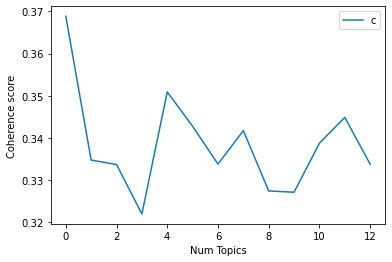

In [26]:
# Show graph

plt.plot(coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
coherence_values

[0.36886522854938175,
 0.3347174015587793,
 0.33366566069149134,
 0.32193697546306127,
 0.350891834354959,
 0.34274045824628724,
 0.3337641007329697,
 0.341710242979732,
 0.32739342988326536,
 0.32708948645250896,
 0.3387296095496725,
 0.34486053990798304,
 0.3337421453771032]

# TF-IDF

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_distances


In [58]:
sample = list(df['re_tll'])
# sample = texts

KeyError: 're_tll'

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X = vec.fit_transform(sample)
X

AttributeError: 'list' object has no attribute 'lower'

In [34]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,00,000,000122,001,00153,002,002001,003,004,004a,...,zzp,zászlós,zélf,èn,én,één,éénmaal,óf,óók,überhaupt
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer 
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [36]:
df

,00,000,000122,001,00153,002,002001,003,004,004a,...,zzp,zászlós,zélf,èn,én,één,éénmaal,óf,óók,überhaupt
0,0.068777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.005225,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,0.054271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1402,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.008664,0.0,0.0,0.0,0.0
1403,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1404,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [37]:
df.stack().reset_index()

,level_0,level_1,0
0,0,00,0.068777
1,0,000,0.000000
2,0,000122,0.000000
3,0,001,0.000000
4,0,00153,0.000000
...,...,...,...
33752431,1405,één,0.000000
33752432,1405,éénmaal,0.000000
33752433,1405,óf,0.000000
33752434,1405,óók,0.000000


In [38]:
tfidf_df = df.stack().reset_index()

In [39]:
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})

In [40]:
tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

,document,term,tfidf
10519,0,kinderen,0.331959
5575,0,de,0.282038
19820,0,tandarts,0.191684
21206,0,van,0.182217
20646,0,trein,0.154522
...,...,...,...
33739767,1405,lichaam,0.189493
33734238,1405,die,0.173966
33737278,1405,hard,0.173694
33737692,1405,hoofd,0.159771


In [41]:
top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

In [65]:
# Doesn't work due to the length constraint of a document (max. 5000)

import altair as alt
import numpy as np

# Terms in this list will get a red dot in the visualization
term_list = ['slachtoffer']

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand = top_tfidf_plusRand.iloc[:5000,]
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf_plusRand.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# red circle over terms in above list
circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')        
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 600)

alt.LayerChart(...)

In [59]:
data_words_nostops[1]

['naan',
 'verdachte',
 'ten',
 'laste',
 'gelegd',
 'wijziging',
 'ter',
 'terechtzitting',
 'hoger',
 'beroep',
 'nhij',
 'omstreeks',
 'november',
 'amsterdam',
 'ander',
 'anderen',
 'openbare',
 'weg',
 'damstraat',
 'elk',
 'geval',
 'openbare',
 'weg',
 'openlijk',
 'vereniging',
 'geweld',
 'gepleegd',
 'verbalisant',
 'waaronder',
 'verbalisant',
 'werkzaam',
 'hoofdinspecteur',
 'politie',
 'amsterdam',
 'amstelland',
 'welk',
 'geweld',
 'bestond',
 'eenmaal',
 'meermalen',
 'kracht',
 'gooien',
 'werpen',
 'vol',
 'le',
 'blikje',
 'bier',
 'fles',
 'sen',
 'elk',
 'geval',
 'hard',
 'voorwerp',
 'richting',
 'verbalisant',
 'eenmaal',
 'meermalen',
 'kracht',
 'vuist',
 'slaande',
 'beweging',
 'richting',
 'lichaam',
 'voornoemde',
 'verbalisant',
 'maken',
 'eenmaal',
 'meermalen',
 'kracht',
 'vast',
 'pakken',
 'vast',
 'houden',
 'nek',
 'zogenaamde',
 'nekklem',
 'voornoemde',
 'verbalisant']

(5000, 3)